In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks', color_codes=True)

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

%matplotlib inline

In [2]:
# rdf = pd.read_csv('drug/drug100_rdf.csv.gz', index_col=0).rename(columns={'radical1': 'fragment1', 'radical2': 'fragment2'})


rdf = pd.read_csv('drug/rdf_drug_190509.csv.gz')

rdf = rdf.drop_duplicates(subset=['molecule', 'fragment1', 'fragment2'])
rdf.head()

,rid,molecule,bond_index,fragment1,fragment2,bde,bond_type,delta_stereo
0,848178,CCN(C(C)=O)c1cccc(-c2ccnc3c(C#N)cnn23)c1,28,[H],C[CH]N(C(C)=O)c1cccc(-c2ccnc3c(C#N)cnn23)c1,92.541262,C-H,0
2,848183,CCN(C(C)=O)c1cccc(-c2ccnc3c(C#N)cnn23)c1,33,[H],CCN(C(C)=O)c1[c]ccc(-c2ccnc3c(C#N)cnn23)c1,111.369042,C-H,0
3,848184,CCN(C(C)=O)c1cccc(-c2ccnc3c(C#N)cnn23)c1,34,[H],CCN(C(C)=O)c1c[c]cc(-c2ccnc3c(C#N)cnn23)c1,113.550264,C-H,0
4,848185,CCN(C(C)=O)c1cccc(-c2ccnc3c(C#N)cnn23)c1,35,[H],CCN(C(C)=O)c1cc[c]c(-c2ccnc3c(C#N)cnn23)c1,111.722330,C-H,0
5,848187,CCN(C(C)=O)c1cccc(-c2ccnc3c(C#N)cnn23)c1,37,[H],CCN(C(C)=O)c1cccc(-c2c[c]nc3c(C#N)cnn23)c1,106.768774,C-H,0


In [3]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


In [4]:
import pickle
import gzip

with gzip.open('processed_inputs_190531.p.gz', 'rb') as f:
    preprocessor_data = pickle.load(f)
    
preprocessor = preprocessor_data['preprocessor']
inputs = preprocessor.predict(rdf.molecule.unique())

100%|██████████| 87/87 [00:00<00:00, 365.32it/s]


In [5]:
from keras.models import load_model
from nfp import custom_layers
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    model = load_model('layer_runs2/n_message_6/best_model.hdf5', custom_objects=custom_layers)
    
from preprocessor_utils import ConcatGraphSequence
new_pred = model.predict_generator(
    ConcatGraphSequence(inputs, batch_size=128, shuffle=False), verbose=1)

1/1 [==============================] - 2s 2s/step


In [6]:
def get_df(iinput, smiles, i):
    idf = pd.DataFrame(iinput['bond_indices'], columns=['bond_index'])
    idf['preprocessor_class'] = iinput['bond']
    idf['molecule'] = smiles
    idf['mol_index'] = i
    return idf

y_new_df = pd.concat([
    get_df(iinput, smiles, i) for i, (iinput, smiles)
    in enumerate(zip(inputs, rdf.molecule.unique()))])

y_new_df['bde_pred'] = new_pred
y_new_df = y_new_df.groupby(['molecule', 'bond_index']).mean().reset_index()
y_new_df.head()

,molecule,bond_index,preprocessor_class,mol_index,bde_pred
0,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]4...,0,25.0,72.0,95.997368
1,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]4...,1,2.0,72.0,117.316711
2,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]4...,2,4.5,72.0,88.336060
3,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]4...,3,27.0,72.0,72.348000
4,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]4...,4,27.0,72.0,88.060059


In [7]:
db_with_pred = rdf.merge(
    y_new_df[['molecule', 'bond_index', 'bde_pred']],
    on=['molecule', 'bond_index'], how='left')

db_with_pred.head()

,rid,molecule,bond_index,fragment1,fragment2,bde,bond_type,delta_stereo,bde_pred
0,848178,CCN(C(C)=O)c1cccc(-c2ccnc3c(C#N)cnn23)c1,28,[H],C[CH]N(C(C)=O)c1cccc(-c2ccnc3c(C#N)cnn23)c1,92.541262,C-H,0,93.702225
1,848183,CCN(C(C)=O)c1cccc(-c2ccnc3c(C#N)cnn23)c1,33,[H],CCN(C(C)=O)c1[c]ccc(-c2ccnc3c(C#N)cnn23)c1,111.369042,C-H,0,110.130157
2,848184,CCN(C(C)=O)c1cccc(-c2ccnc3c(C#N)cnn23)c1,34,[H],CCN(C(C)=O)c1c[c]cc(-c2ccnc3c(C#N)cnn23)c1,113.550264,C-H,0,110.648926
3,848185,CCN(C(C)=O)c1cccc(-c2ccnc3c(C#N)cnn23)c1,35,[H],CCN(C(C)=O)c1cc[c]c(-c2ccnc3c(C#N)cnn23)c1,111.722330,C-H,0,112.210480
4,848187,CCN(C(C)=O)c1cccc(-c2ccnc3c(C#N)cnn23)c1,37,[H],CCN(C(C)=O)c1cccc(-c2c[c]nc3c(C#N)cnn23)c1,106.768774,C-H,0,108.150131


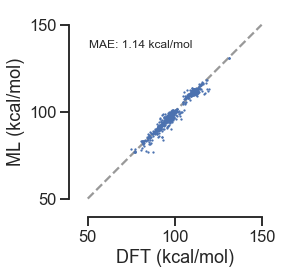

In [17]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
plt.plot(db_with_pred.bde, db_with_pred.bde_pred, '.', ms=2.5)
plt.plot([50, 150], [50, 150], '--', zorder=0, color='.6')

ax.text(.05, .875,
        'MAE: {:0.2f} kcal/mol'.format((db_with_pred.bde - db_with_pred.bde_pred).abs().mean()),
        transform=ax.transAxes, ha='left', va='top', fontsize='large')

ax.set_yticks([50, 100, 150])

sns.despine(offset=10, trim=True)

ax.set_ylabel('ML (kcal/mol)')
ax.set_xlabel('DFT (kcal/mol)')

plt.tight_layout()
plt.savefig('drug_predictions.svg')

In [9]:
rdf.shape

(748, 8)

In [10]:
len(rdf.molecule.unique())

87

In [11]:
db_with_pred.shape

(748, 9)